# 1. Install needed libraries

In [1]:
!pip install ../input/sacremoses/sacremoses-master/ > /dev/null

In [2]:
!pip install /kaggle/input/transformers/transformers-2.2.1-py3-none-any.whl

Processing /kaggle/input/transformers/transformers-2.2.1-py3-none-any.whl


In [3]:
!pip install transformers

# 2. load data

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/transformers/transformers-2.2.1-py3-none-any.whl
/kaggle/input/distilbertbaseuncased/vocab.txt
/kaggle/input/distilbertbaseuncased/config.json
/kaggle/input/distilbertbaseuncased/pytorch_model.bin
/kaggle/input/sacremoses/sacremoses-master/CONTRIBUTORS.md
/kaggle/input/sacremoses/sacremoses-master/README.md
/kaggle/input/sacremoses/sacremoses-master/.appveyor.yml
/kaggle/input/sacremoses/sacremoses-master/requirements.txt
/kaggle/input/sacremoses/sacremoses-master/setup.py
/kaggle/input/sacremoses/sacremoses-master/.travis.yml
/kaggle/input/sacremoses/sacremoses-master/sacremoses/tokenize.py
/kaggle/input/sacremoses/sacremoses-master/sacremoses/subwords.py
/kaggle/input/sacremoses/sacremoses-master/sacremoses/util.py
/kaggle/input/sacremoses/sacremoses-master/sacremoses/chinese.py
/kaggle/input/sacremoses/sacremoses-master/sacremoses/normalize.py
/kaggle/input/sacremoses/sacremoses-master/sacremoses/cli.py
/kaggle/input/sacremoses/sacremoses-master/sacremoses/__init__.py


In [5]:
df_submit = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_train.text = df_train.text.astype(str)
df_test.text = df_test.text.astype(str)

In [6]:
df_train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [7]:
import os
import sys
import glob
import torch
import time
from tqdm import tqdm_notebook as tqdm
import transformers
# DEVICE = torch.device("cuda")
tokenizer = transformers.DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
# tokenizer = transformers.DistilBertTokenizer.from_pretrained("../input/distilbertbaseuncased/")
# model = transformers.DistilBertModel.from_pretrained("../input/distilbertbaseuncased/")
# model.to(DEVICE)

100%|██████████| 231508/231508 [00:00<00:00, 1247940.39B/s]


# 3. Preprocess the data for training

In [8]:
### SINCE WHOLE USEFUL VECTORS ARE 125, we can just use 129...
### [CLS] + text[82] + [SEP] + location[30] + [SEP] + keyword[7] + [SEP]

def to_ids(tokenizer, text):
    ids = []
    tokens = tokenizer.tokenize(text)
    for token in tokens:
        ids.append(tokenizer._convert_token_to_id(token))
    return ids
def pad_to_length(ids, length):
    ids = ids[:length]
    if len(ids) < length:
        ids += ([0] * (length - len(ids)))
    return ids
def join_segments(tokenizer, *segments):
    vector = [tokenizer._convert_token_to_id('[CLS]')]
    sep_id = tokenizer._convert_token_to_id('[SEP]')
    for segment in segments:
        vector += segment
        vector.append(sep_id)
    return vector


In [9]:
train_vectors = []
for _, (text, location, keyword) in tqdm(df_train[['text', 'location', 'keyword']].fillna("-").iterrows(), total=df_train.shape[0]):
    text_ids = pad_to_length(to_ids(tokenizer, text), 85)
    location_ids = pad_to_length(to_ids(tokenizer, location), 31)
    keyword_ids = pad_to_length(to_ids(tokenizer, keyword), 8)
    train_vectors.append(join_segments(tokenizer, text_ids, location_ids, keyword_ids))
X_train = np.array(train_vectors)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [10]:
test_vectors = []
for _, (text, location, keyword) in tqdm(df_test[['text', 'location', 'keyword']].fillna("-").iterrows(), total=df_test.shape[0]):
    text_ids = pad_to_length(to_ids(tokenizer, text), 85)
    location_ids = pad_to_length(to_ids(tokenizer, location), 31)
    keyword_ids = pad_to_length(to_ids(tokenizer, keyword), 8)
    test_vectors.append(join_segments(tokenizer, text_ids, location_ids, keyword_ids))
X_test = np.array(test_vectors)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [11]:
y_train = df_train.target.values

## See if there is a severe class imbalance...

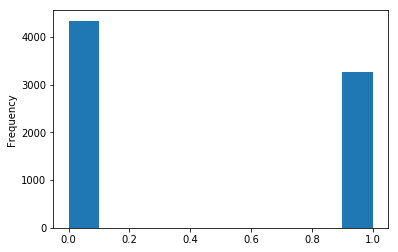

In [12]:
df_train.target.plot.hist()

# 4. Train with customized DistilBert classifiers per each fold
 - After training and validating with each fold, use each classifier to calculate probabilities

In [13]:
from transformers import DistilBertForSequenceClassification, DistilBertModel

In [14]:
from torch.nn import BCEWithLogitsLoss
from torch import nn
from tqdm.notebook import tqdm
from tqdm import trange
from transformers import AdamW
from torch.optim import Adam
from sklearn.metrics import f1_score, precision_score, recall_score
import torch.nn.functional as F
def train(model, num_epochs, train_dataloader, valid_dataloader, crit_function=nn.CrossEntropyLoss(), device='cpu'):
#     optimizer = AdamW(model.parameters(), lr=3.5e-5, weight_decay=0.01, correct_bias=False)
#     model.to(device)
    """
    Train the model and save the model with the lowest validation loss
    """
#     crit_function = nn.BCEWithLogitsLoss()
    model.to(device)
    start_epoch = 0
#     optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01, correct_bias=False)
    optimizer = Adam(model.parameters(), lr=1.5e-5, weight_decay=0.00)

#     optimizer = torch.optim.Adamax(model.parameters(), lr=3e-5)
    # trange is a tqdm wrapper around the normal python range
    for i in trange(num_epochs, desc="Epoch"):
        # if continue training from saved model
        actual_epoch = start_epoch + i
        # Set our model to training mode (as opposed to evaluation mode)
        model.train()

        # Tracking variables
        tr_loss = 0
        num_train_samples = 0

        t = tqdm(total=len(train_data), desc="Training: ", position=0)
        # Train the data for one epoch
        for step, batch in enumerate(train_dataloader):
            # Add batch to GPU
            batch = tuple(t.to(device) for t in batch)
            # Unpack the inputs from our dataloader
            b_input_ids, b_labels = batch
            # Clear out the gradients (by default they accumulate)
            optimizer.zero_grad()
            # Forward pass
            loss = model(b_input_ids, labels=b_labels)
            # store train loss
#             print(loss)
            loss = loss[0]
#             input()
            tr_loss += loss.item()
            num_train_samples += b_labels.size(0)
            # Backward pass
            loss.backward()
            # Update parameters and take a step using the computed gradient
            optimizer.step()
            #scheduler.step()
            t.update(n=b_input_ids.shape[0])
        t.close()
        # Update tracking variables
        epoch_train_loss = tr_loss/num_train_samples*batch_size
#         train_loss_set.append(epoch_train_loss)

        print("Train loss: {}".format(epoch_train_loss))

        # Validation

        # Put model in evaluation mode to evaluate loss on the validation set
        model.eval()

        # Tracking variables 
        eval_loss = 0
        num_eval_samples = 0

        v_preds = []
        v_labels = []

        # Evaluate data for one epoch
        t = tqdm(total=len(validation_data), desc="Validating: ", position=0)
        eval_losses = []
        for batch in valid_dataloader:
            # Add batch to GPU
            batch = tuple(t.to(device) for t in batch)
            # Unpack the inputs from our dataloader
            b_input_ids,b_labels = batch
            # Telling the model not to compute or store gradients,
            # saving memory and speeding up validation
            with torch.no_grad():
                # Forward pass, calculate validation loss
                logits = model(b_input_ids)[0]
#                 print(b_labels)
#                 print(logits)
                loss = crit_function(logits.view(-1, 2),b_labels.view(-1))
#                 print(loss)
                preds = torch.argmax(F.softmax(logits.view(-1, 2), dim=-1), dim=-1)
#                 print(preds)
#                 input()
                v_labels.append(b_labels.cpu().numpy())
                v_preds.append(preds.cpu().numpy())
                # store valid loss
                eval_losses.append(loss.item())
                num_eval_samples += b_labels.size(0)
            t.update(n=b_labels.shape[0])
        t.close()

        v_labels = np.hstack(v_labels)
        v_preds = np.hstack(v_preds)
        print(v_labels.shape)
        epoch_eval_loss = sum(eval_losses)/len(eval_losses)
#         valid_loss_set.append(epoch_eval_loss)
        print('Epoch #{} Validation Results:'.format(i + 1))
        print('\tvalidation BCE loss: ~{}'.format(epoch_eval_loss))
        print('\tF1: {}'.format(f1_score(v_labels, v_preds)))
        print('\tPrecision: {}'.format(precision_score(v_labels, v_preds)))
        print('\tRecall: {}'.format(recall_score(v_labels, v_preds)))
        print("\n")

    return model

In [15]:
def get_pred_probs(model, test_dataloader, test_length ,device):
    model.eval()
    model.to(device)

    # Tracking variables 
    eval_loss = 0
    num_eval_samples = 0

    v_preds = []
    v_probs = []

    # Evaluate data for one epoch
    t = tqdm(total=test_length, desc="Inferencing test data: ", position=0)
    eval_losses = []
    for batch in test_dataloader:
        # Add batch to GPU
#         print(batch)
#         input('PAUSED')
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids= batch[0]
        with torch.no_grad():
            # Forward pass, calculate validation loss
            logits = model(b_input_ids)[0]
            probs = F.softmax(logits.view(-1, 2), dim=-1)
            preds = torch.argmax(probs, dim=-1)
            v_probs.append(probs.cpu().numpy())
            v_preds.append(preds.cpu().numpy())
        t.update(n=probs.shape[0])
    t.close()
    probs = np.vstack(v_probs)
    classifications = np.hstack(v_preds)
    
    return probs, classifications

In [16]:
import logging
import math

import torch
from torch import nn
from torch.nn import CrossEntropyLoss, MSELoss
from torch.nn import functional as F

from transformers.modeling_distilbert import DistilBertPreTrainedModel
from transformers.modeling_bert import BertPreTrainedModel
from transformers.file_utils import add_start_docstrings
from transformers.modeling_utils import PoolerAnswerClass, PoolerEndLogits, PoolerStartLogits, PreTrainedModel, SequenceSummary



### Credit: HuggingFace @ Github

In [17]:
class DistilBertForSequenceClassification(DistilBertPreTrainedModel):
    r"""
        **labels**: (`optional`) ``torch.LongTensor`` of shape ``(batch_size,)``:
            Labels for computing the sequence classification/regression loss.
            Indices should be in ``[0, ..., config.num_labels - 1]``.
            If ``config.num_labels == 1`` a regression loss is computed (Mean-Square loss),
            If ``config.num_labels > 1`` a classification loss is computed (Cross-Entropy).

    Outputs: `Tuple` comprising various elements depending on the configuration (config) and inputs:
        **loss**: (`optional`, returned when ``labels`` is provided) ``torch.FloatTensor`` of shape ``(1,)``:
            Classification (or regression if config.num_labels==1) loss.
        **logits**: ``torch.FloatTensor`` of shape ``(batch_size, config.num_labels)``
            Classification (or regression if config.num_labels==1) scores (before SoftMax).
        **hidden_states**: (`optional`, returned when ``config.output_hidden_states=True``)
            list of ``torch.FloatTensor`` (one for the output of each layer + the output of the embeddings)
            of shape ``(batch_size, sequence_length, hidden_size)``:
            Hidden-states of the model at the output of each layer plus the initial embedding outputs.
        **attentions**: (`optional`, returned when ``config.output_attentions=True``)
            list of ``torch.FloatTensor`` (one for each layer) of shape ``(batch_size, num_heads, sequence_length, sequence_length)``:
            Attentions weights after the attention softmax, used to compute the weighted average in the self-attention heads.

    Examples::

        tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
        input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0)  # Batch size 1
        labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
        outputs = model(input_ids, labels=labels)
        loss, logits = outputs[:2]

    """

    def __init__(self, config):
        super(DistilBertForSequenceClassification, self).__init__(config)
        self.num_labels = config.num_labels

        self.distilbert = DistilBertModel(config)
        self.pre_classifier = nn.Linear(config.dim, config.dim)
        self.classifier = nn.Linear(config.dim, config.num_labels)
        self.dropout = nn.Dropout(config.seq_classif_dropout)

        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, head_mask=None, inputs_embeds=None, labels=None):
        distilbert_output = self.distilbert(
            input_ids=input_ids, attention_mask=attention_mask, head_mask=head_mask, inputs_embeds=inputs_embeds
        )
        hidden_state = distilbert_output[0]  # (bs, seq_len, dim)
#         pooled_output = torch.mean(hidden_state, 1)
        pooled_output = hidden_state[:, 0]  # (bs, dim)
        pooled_output = self.pre_classifier(pooled_output)  # (bs, dim)
        pooled_output = nn.SELU()(pooled_output)  # (bs, dim)
        pooled_output = self.dropout(pooled_output)  # (bs, dim)
        logits = self.classifier(pooled_output)  # (bs, dim)

        outputs = (logits,) + distilbert_output[1:]
        if labels is not None:
            if self.num_labels == 1:
                loss_fct = nn.MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                loss_fct = nn.CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

In [18]:
import gc
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, DataLoader
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
batch_size = 16
kf = StratifiedKFold(n_splits=7, random_state=8980, shuffle=True)
kf.get_n_splits(X_train, y_train)
probs_from_folds = []
for ind, (tr, val) in enumerate(kf.split(X_train, y_train)):
    # new model per split
    print("FOLD #{} STARTING!".format(ind + 1))
    model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")
    
#     model = DistilBertForSequenceClassification.from_pretrained("../input/distilbertbaseuncased/")
    
    # split train datatset
    X_tr = X_train[tr]
    y_tr = y_train[tr]
    X_val = X_train[val]
    y_val = y_train[val]
    
    # convert train dataset
    X_tr = torch.tensor(X_tr)
    X_val = torch.tensor(X_val)
    y_tr = torch.tensor(y_tr, dtype=torch.long)
    y_val = torch.tensor(y_val, dtype=torch.long)
    
    # prepare train dataloader
    train_data = TensorDataset(X_tr, y_tr)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data,\
                                  sampler=train_sampler,\
                                  batch_size=batch_size)

    validation_data = TensorDataset(X_val, y_val)
    validation_sampler = SequentialSampler(validation_data)
    validation_dataloader = DataLoader(validation_data,\
                                       sampler=validation_sampler,\
                                       batch_size=batch_size)
    
    #start training!
    model = train(model=model, num_epochs=2,\
                  train_dataloader=train_dataloader, valid_dataloader=validation_dataloader,
                  device='cuda')
    
    
    # prepare test data
    test_data = torch.tensor(X_test)
    test_data = TensorDataset(test_data)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data,\
                                       sampler=test_sampler,\
                                       batch_size=batch_size)
    
    probs, _ = get_pred_probs(model, test_dataloader,\
                   test_length=df_test.shape[0] ,device='cuda')
    probs_from_folds.append(probs)
    del model
    torch.cuda.empty_cache()
    gc.collect()
    
    
    

FOLD #1 STARTING!


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]


Train loss: 0.4484402725551846


Epoch:  50%|█████     | 1/2 [00:51<00:51, 51.45s/it]


(1089,)
Epoch #1 Validation Results:
	validation BCE loss: ~0.35912983357042505
	F1: 0.832967032967033
	Precision: 0.8574660633484162
	Recall: 0.8098290598290598





Train loss: 0.34132938153680886


Epoch: 100%|██████████| 2/2 [01:41<00:00, 50.96s/it]


(1089,)
Epoch #2 Validation Results:
	validation BCE loss: ~0.3479552617755489
	F1: 0.8326180257510729
	Precision: 0.8362068965517241
	Recall: 0.8290598290598291





FOLD #2 STARTING!


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]


Train loss: 0.4415757777426303


Epoch:  50%|█████     | 1/2 [00:50<00:50, 50.37s/it]


(1089,)
Epoch #1 Validation Results:
	validation BCE loss: ~0.40625486987224524
	F1: 0.7711111111111111
	Precision: 0.8032407407407407
	Recall: 0.7414529914529915





Train loss: 0.33405986908825536


Epoch: 100%|██████████| 2/2 [01:40<00:00, 50.36s/it]


(1089,)
Epoch #2 Validation Results:
	validation BCE loss: ~0.39564196004167845
	F1: 0.7762237762237763
	Precision: 0.8538461538461538
	Recall: 0.7115384615384616





FOLD #3 STARTING!


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]


Train loss: 0.44763266267566054


Epoch:  50%|█████     | 1/2 [00:50<00:50, 50.82s/it]


(1087,)
Epoch #1 Validation Results:
	validation BCE loss: ~0.3891075317035703
	F1: 0.7636363636363636
	Precision: 0.8798882681564246
	Recall: 0.6745182012847966





Train loss: 0.4845773057633662


Epoch:  50%|█████     | 1/2 [00:50<00:50, 50.37s/it]


(1087,)
Epoch #1 Validation Results:
	validation BCE loss: ~0.38249963817789273
	F1: 0.7880952380952382
	Precision: 0.8873994638069705
	Recall: 0.708779443254818





Train loss: 0.3557772442785246


Epoch: 100%|██████████| 2/2 [01:40<00:00, 50.41s/it]


(1087,)
Epoch #2 Validation Results:
	validation BCE loss: ~0.38654325294363145
	F1: 0.8078175895765473
	Precision: 0.8193832599118943
	Recall: 0.7965738758029979





FOLD #6 STARTING!


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]


Train loss: 0.45829101873620537


Epoch:  50%|█████     | 1/2 [00:50<00:50, 50.76s/it]


(1087,)
Epoch #1 Validation Results:
	validation BCE loss: ~0.39888832959182124
	F1: 0.8041002277904328
	Precision: 0.8588807785888077
	Recall: 0.7558886509635975





Train loss: 0.3356329307046873


Epoch: 100%|██████████| 2/2 [01:41<00:00, 50.62s/it]


(1087,)
Epoch #2 Validation Results:
	validation BCE loss: ~0.3950046768192859
	F1: 0.8137472283813747
	Precision: 0.8436781609195402
	Recall: 0.7858672376873662





FOLD #7 STARTING!


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]


Train loss: 0.4417918698392395


Epoch:  50%|█████     | 1/2 [00:50<00:50, 50.50s/it]


(1087,)
Epoch #1 Validation Results:
	validation BCE loss: ~0.41086557156899395
	F1: 0.7921225382932167
	Precision: 0.8098434004474273
	Recall: 0.7751605995717344





Train loss: 0.33568360539363856


Epoch: 100%|██████████| 2/2 [01:41<00:00, 50.62s/it]


(1087,)
Epoch #2 Validation Results:
	validation BCE loss: ~0.4336441752007779
	F1: 0.7653179190751446
	Precision: 0.8316582914572864
	Recall: 0.708779443254818




# 5. Calculate mean probabilities from accumulated predictions

In [19]:
pff = np.array(probs_from_folds)
pff_mean = np.mean(pff, axis=0)

In [20]:
pff_mean

array([[0.07302676, 0.9269732 ],
       [0.0284406 , 0.97155935],
       [0.04698179, 0.9530182 ],
       ...,
       [0.00535013, 0.9946499 ],
       [0.11765403, 0.882346  ],
       [0.21206297, 0.7879371 ]], dtype=float32)

# 6. Convert softmaxed probs to class

In [21]:
preds = np.argmax(pff_mean, axis=1)

# 7. SUBMIT!

In [22]:
df_submit['target'] = preds

In [23]:
df_submit

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [24]:
df_submit.to_csv('submission.csv', index=False)

[SUBMISSION FILE](./submission.csv)